# <center> 🤿 Погружение в Агентов LangChain  </center>
### <center> 😎 Создаём "суперагента" 🕵️‍♂️ </center>

### Оглавление ноутбука
<img src='../images/ag2.webp' align="right" width="500" height="428" >
<br>

<p><font size="3" face="Arial" font-size="large"><ul type="square">
    
<li><a href="#p1">🤖 Основные типы агентов и их суперспособности 🦾</a></li>
<li><a href="#p2">🚀 ReAct Agent 🔄</a></li><ul type="square">
<li><a href="#p2.1">🔎 Инструмент поиск Google (SerpAPI) 🔎</a></li></ul>
<li><a href="#p3">💬 Structured Chat Agent 💬</a></li>
<li><a href="#p4">🙋🏻 Self-Ask with search Agent ❓</a></li>
<li><a href="#p5">😎 Агент, который всё помнит! 🫣</a></li>
<li><a href="#p6">🪛 OpenAI Tools Agent + RAG 🦞</a></li>
<li><a href="#p7">🙋🏻 Agent с sql базой 📊</a></li><ul type="square">
<li><a href="#p7.1"> 🫂 SQL агент + python агент = super агент 😎</a></li></ul>
<li><a href="#p8">Задеплой Агента с помощью LangServe 🛋 </a></li>
<li><a href="#p9">🥁 Выводы и заключения ✅ </a></li>


    
</ul></font></p>

### 🧑‍🎓 В этом уроке более подробно погрузимся в возможности агентов с LangChain.

# <center  id="p1"> 🤖 Основные типы агентов и их суперспособности 🦾 </center>

<div class="alert alert-info">
    
📖 В `LangChain` представлены агенты 5 основных типов (`Agent Types`):
* `ReAct (Reasoning and Acting)` - агенты такого типа создаются по умолчанию, работают с инструментами, принимающими один параметр на вход.
* `Structured chat` - могут работать с инструментами, которые принимают много параметров на вход
* `Self Ask with Search` - реализация техники промптинга `Self-Ask`, работает только с инструментами поиска
* `XMLAgent, JSONAgent` - для работы с чат моделями в форматах `XML` и `JSON` (например, модели от `Anthropic`)
* `OpenAI Tools Agents` - пришли на замену `OpenAIFunctions Agents` (OpenAI перестает их поддерживать). Могут вызывать сразу одну или несколько функций, тем самым сокращая время для получения ответа - работает с последними моделями от OpenAI.

<div class="alert alert-success">
    
Рассмотрим подробнее первые три типа агентов. <br>
Каждый агент "под капотом" содержит тот или иной промпт завернутый в удобную обертку агента `LangChain`.

In [1]:
# !pip install langchain langchain-openai openai langchainhub google-search-results faiss-cpu langchain-experimental langserve -q

In [6]:
import os
from getpass import getpass

In [2]:
# Для работы в колабе загрузите наш скрипт для использования ChatGPT с ключом курса, и необходимые файлы!
# !mkdir ../data/
# !wget -P ../data https://raw.githubusercontent.com/a-milenkin/LLM_practical_course/main/data/pizzeria.db
# !wget https://raw.githubusercontent.com/a-milenkin/LLM_practical_course/main/notebooks/utils.py

In [3]:
# # Если используете ключ от OpenAI, запустите эту ячейку
# from langchain_openai import ChatOpenAI

# # os.environ['OPENAI_API_KEY'] = "Введите ваш OpenAI API ключ"
# os.environ['OPENAI_API_KEY'] = getpass(prompt='Введите ваш OpenAI API ключ')

# # инициализируем языковую модель
# llm = ChatOpenAI(temperature=0.0)

In [8]:
# Если используете ключ из курса, запустите эту ячейку
from utils import ChatOpenAI

# course_api_key= "Введите ваш ключ, полученный в боте курса"
course_api_key = getpass(prompt="Введите ваш ключ, полученный в боте курса:")

# инициализируем языковую модель
llm = ChatOpenAI(temperature=0.0, course_api_key=course_api_key)

Введите ваш ключ, полученный в боте курса: ········


# <center  id="p2"> `ReAct` `Agent` - сначала придумай план, потом делай!🚀</center>

<img src='../images/react_sch.png' align="right" width="550" height="428" >
<br>
<div class="alert alert-info">
    
Этот тип агента реализуется на основе техники `ReAct Prompting` представленной командой GoogleResearch в 2022 году в статье [ReAct: Synergizing Reasoning and Acting in Language Models](https://arxiv.org/abs/2210.03629).

**`ReAct`** объединила в себе два подхода:
* **`Reasoning`** (техника Chain of Thoughts)
* **`Acting`** (Action Plan Generation - генерация плана действий)


<div class="alert alert-success">
    
#### Посмотрим как выглядит шаблон промпта ReAct агента в `LangChain`:
```
Answer the following questions as best you can. You have access to the
following tools:
{tools}
Use the following format:
Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question
Begin!
Question: {input}
Thought:{agent_scratchpad}
```

<div class="alert alert-success">
    
Шаблоны промптов, используемые в агентах (и не только) хранятся в [LangChain Hub](https://smith.langchain.com/hub). Туда, примерно так же, как на `GitHub`, можно загружать свои промпты и потом удобно ими пользоваться. 🤗

In [16]:
from langchain import hub

prompt = hub.pull("hwchase17/react")
print(prompt)

input_variables=['agent_scratchpad', 'input', 'tool_names', 'tools'] template='Answer the following questions as best you can. You have access to the following tools:\n\n{tools}\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)\nThought: I now know the final answer\nFinal Answer: the final answer to the original input question\n\nBegin!\n\nQuestion: {input}\nThought:{agent_scratchpad}'


<div class="alert alert-success">

🤔 Видим шаблон промпта, который обсуждали выше и служебные переменные.

### <center  id="p2.1"> 🚮 Добавим инструмент - Google-поиск (SerpAPI) 🔎</center>
<div class="alert alert-info">
    
Для использования поисковика Google по API необходимо: зарегистрироваться на сайте [serpapi.com](https://serpapi.com) и получить API-ключ.
На бесплатном тарифе доступно 100 запросов в месяц.

In [4]:
import langchain
from langchain.agents import AgentType, initialize_agent, load_tools, tool

In [5]:
# Добавляем полученный ключ в переменную среды
os.environ["SERPAPI_API_KEY"] = getpass(prompt="Введите ваш ключ SerpApi:")

Введите ваш ключ SerpApi: ········


In [11]:
# Легаси интерфейс и его недостатки
tools = load_tools(["serpapi"], llm=llm)

agent = initialize_agent(
    tools,
    llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, # Указывается тип агента, непонятно с каким промптом
    handle_parsing_errors = True, # Агент не упадёт с ошибкой, если не распарсит ответ
    verbose=True)
#langchain.debug = True # включение Debug режима, для отслеживания рассуждений агента
langchain.debug = False

agent.invoke('Какая температура в Сочи?')



> Entering new AgentExecutor chain...
I need to find the current temperature in Sochi.
Action: Search
Action Input: "current temperature in Sochi"
Observation: {'type': 'weather_result', 'temperature': '62', 'unit': 'Fahrenheit', 'precipitation': '3%', 'humidity': '60%', 'wind': '7 mph', 'location': 'Sochi, Russia', 'date': 'Monday 4:00 PM', 'weather': 'Mostly cloudy'}
Thought:The current temperature in Sochi is 62 degrees Fahrenheit.
Final Answer: The current temperature in Sochi is 62 degrees Fahrenheit.

> Finished chain.


{'input': 'Какая температура в Сочи?',
 'output': 'The current temperature in Sochi is 62 degrees Fahrenheit.'}

<div class="alert alert-success">
    
В легаси интерфейсе, не было явно видно какой именно промпт используется для агента и откуда он берется? Новый интерфейс создания агентов позволяет явно указывать промпт используемый в работе агента. <br>
Так же это открывает простой путь к кастомизации промптов для агентов, если дефолтные промпты не подходят для нашей конкретной задачи:
* Берем стандартный промпт, изменяем его. Или пишем собственный с нуля.
* Загружаем на `langchainhub`
* При необходимости подгружаем с хаба и пользуемся.

In [19]:
from langchain.agents import AgentExecutor, create_react_agent

tools = load_tools(["serpapi"], llm=llm)
langchain.debug = False

# В новом интерфейсе явно задается используемый промпт
prompt = hub.pull("hwchase17/react")

agent = create_react_agent(llm, tools, prompt)

agent_executor = AgentExecutor(agent=agent,
                               tools=tools, 
                               verbose=True,
                               max_iterations=15, # максимальное количество итераций агента (15 по умолчанию)
                               handle_parsing_errors=True)

agent_executor.invoke({"input": "Температура в Сочи? Ответь в Цельсиях"})



> Entering new AgentExecutor chain...
I need to find the current temperature in Sochi in Celsius.
Action: Search
Action Input: "current temperature in Sochi in Celsius"{'type': 'weather_result', 'temperature': '17', 'unit': 'Celsius', 'precipitation': '2%', 'humidity': '60%', 'wind': '11 km/h', 'location': 'Sochi, Russia', 'date': 'Monday 4:00 PM', 'weather': 'Mostly cloudy'}The current temperature in Sochi is 17 degrees Celsius.
Final Answer: 17 degrees Celsius.

> Finished chain.


{'input': 'Температура в Сочи? Ответь в Цельсиях',
 'output': '17 degrees Celsius.'}

In [21]:
# Создадим свой tool, вычисляющий площадь треугольника
from langchain.agents import tool

@tool
def compute_triangle_area(a, b, c):
    """Вычисляет площадь треугольника по длинам его сторон"""
    s = (a + b + c) / 2
    return (s * (s - a) * (s - b) * (s - c)) ** 0.5

In [22]:
# Добавим его к поиску
tools.append(compute_triangle_area)

In [23]:
tools[1] 

StructuredTool(name='compute_triangle_area', description='compute_triangle_area(a, b, c) - Вычисляет площадь треугольника по длинам его сторон', args_schema=<class 'pydantic.v1.main.compute_triangle_areaSchema'>, func=<function compute_triangle_area at 0x7f3431b288b0>)

In [ ]:
agent = create_react_agent(llm, tools, prompt)

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

agent_executor.invoke({"input": "Посчитай площадь треугольника со сторонами 2, 2, 2"})

<div class="alert alert-warning">
    
Получим ошибку: `ValidationError` <br>

<img src='../images/ag_err.png'  width="808" height="628" >

Это происходит из-за того, что `ReAct` агент не может применять `StructuredTool` - инструменты, принимающие на вход несколько параметров.

<div class="alert alert-success">
    
🤗 Для работы с такими инструментами применяется другой тип агента `Structured Chat Agent`.

# <center id="p3"> Structured Chat Agent 💬</center>

<div class="alert alert-info">
    
Не сильно отличается от `ReAct` агента - просто в промпт добавлены специальные инструкции и шаги для работы с `multi-input tools`. 

In [25]:
# Посмотрим на промпт Structured Chat агента, используемый по умолчанию
prompt = hub.pull("hwchase17/structured-chat-agent")
print(prompt.messages[0].prompt.template)

Respond to the human as helpfully and accurately as possible. You have access to the following tools:

{tools}

Use a json blob to specify a tool by providing an action key (tool name) and an action_input key (tool input).

Valid "action" values: "Final Answer" or {tool_names}

Provide only ONE action per $JSON_BLOB, as shown:

```
{{
  "action": $TOOL_NAME,
  "action_input": $INPUT
}}
```

Follow this format:

Question: input question to answer
Thought: consider previous and subsequent steps
Action:
```
$JSON_BLOB
```
Observation: action result
... (repeat Thought/Action/Observation N times)
Thought: I know what to respond
Action:
```
{{
  "action": "Final Answer",
  "action_input": "Final response to human"
}}

Begin! Reminder to ALWAYS respond with a valid json blob of a single action. Use tools if necessary. Respond directly if appropriate. Format is Action:```$JSON_BLOB```then Observation


<div class="alert alert-info">

Видим, что по сути, промпт совпадает с промптом `ReAct` агента. 
    
Посмотрим, как справится с задачей `structured_chat_agent`.

In [27]:
from langchain.agents import create_structured_chat_agent

agent = create_structured_chat_agent(llm, tools, prompt)

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

agent_executor.invoke({"input": "Посчитай площадь треугольника со сторонами 2, 2, 2"})



> Entering new AgentExecutor chain...
Thought: The user is asking to calculate the area of a triangle with side lengths of 2, 2, and 2.

Action:
```
{
  "action": "compute_triangle_area",
  "action_input": {
    "a": 2,
    "b": 2,
    "c": 2
  }
}
```1.7320508075688772Action:
```
{
  "action": "Final Answer",
  "action_input": 1.7320508075688772
}
```

> Finished chain.


{'input': 'Посчитай площадь треугольника со сторонами 2, 2, 2',
 'output': 1.7320508075688772}

# <center id="p4"> 🙋🏻 `Self-Ask` with search Agent ❓ </center>

<img src='../images/self.webp' align="right" width="508" height="428" >
<br>
<div class="alert alert-info">
    
Техника `Self-Ask with search` позволяет LLM не сразу отвечать на запрос, а сначала делать промежуточные поисковые запросы и, основываясь на результатах этих запросов, генерировать окончательный ответ. Что даёт прирост в качестве ответов по сравнению с `Zero-shot` и `Chain-of-Taughts` при ответах на сложные запросы.

Агент `Self-Ask with search` может использовать только один инструмент: любой поисковик.

In [17]:
# Если спросить предыдущего агента:
agent_executor.invoke(
    {"input": "Какая самая большая река протекает в городе, в котором родился автор 'Капитанской дочки'?"})



> Entering new AgentExecutor chain...
Action:
```
{
  "action": "Search",
  "action_input": "What is the largest river that flows through the city where the author of 'The Captain's Daughter' was born?"
}
```["The Captain's Daughter is a historical novel by the Russian writer Alexander Pushkin. It was first published in 1836 in the fourth issue of the literary ...", "Found in the seedy wharf district of London, down by the reeking River Thames, the Captain's Daughter was a watering hole renowned for the roughness of its grog ...", 'Sacagawea traveled with the expedition thousands of miles from North Dakota to the Pacific Ocean, helping to establish cultural contacts with Native American ...', 'A love triangle ensues with Shavbran trying to keep Masha and Grinyov apart. As this dramatic love story develops, Pugachev arrives to take over the fort, ...', 'Captain John Smith was an adventurer, soldier, explorer and author. Through the telling of his early life, we can trace the developme

{'input': "Какая самая большая река протекает в городе, в котором родился автор 'Капитанской дочки'?",
 'output': "The largest river that flows through the city where the author of 'The Captain's Daughter' was born is the Neva River."}

<div class="alert alert-warning">
    
Агент пытается получить ответ на сложный вопрос одним поисковым запросом и приходит к неправильному выводу! <br>
Для ответа на подобные вопросы хорошо подходит агент, реализующий технику промптинга `Self-Ask`.

<div class="alert alert-success">
    
#### Посмотрим как выглядит шаблон промпта Self-Ask агента в `LangChain` (по сути это `Few-shot` + `CoT`):
```
Question: Who lived longer, Muhammad Ali or Alan Turing?
Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali

Question: When was the founder of craigslist born?
Are follow up questions needed here: Yes.
Follow up: Who was the founder of craigslist?
Intermediate answer: Craigslist was founded by Craig Newmark.
Follow up: When was Craig Newmark born?
Intermediate answer: Craig Newmark was born on December 6, 1952.
So the final answer is: December 6, 1952

Question: Who was the maternal grandfather of George Washington?
Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Follow up: Who was the father of Mary Ball Washington?
Intermediate answer: The father of Mary Ball Washington was Joseph Ball.
So the final answer is: Joseph Ball

Question: Are both the directors of Jaws and Casino Royale from the same country?
Are follow up questions needed here: Yes.
Follow up: Who is the director of Jaws?
Intermediate answer: The director of Jaws is Steven Spielberg.
Follow up: Where is Steven Spielberg from?
Intermediate answer: The United States.
Follow up: Who is the director of Casino Royale?
Intermediate answer: The director of Casino Royale is Martin Campbell.
Follow up: Where is Martin Campbell from?
Intermediate answer: New Zealand.
So the final answer is: No

Question: {input}
Are followup questions needed here:{agent_scratchpad}
```

In [51]:
from langchain.agents import create_self_ask_with_search_agent, Tool
from langchain_community.utilities import SerpAPIWrapper

prompt = hub.pull("hwchase17/self-ask-with-search")

<div class="alert alert-success">
    
Создадим инструмент - поиск, который **ОБЯЗАТЕЛЬНО** должен называться `Intermediate Answer`.

In [55]:
search = SerpAPIWrapper()
tools = [
    Tool(
        name="Intermediate Answer",
        func=search.run,
        description='useful for when you need to answer questions'
    )
]

In [56]:
agent = create_self_ask_with_search_agent(llm, tools, prompt)

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)

agent_executor.invoke({"input": "Какая самая большая река протекает в городе, в котором родился автор романа Капитанская дочка?"})



> Entering new AgentExecutor chain...
 Yes. 
Follow up: Кто автор романа "Капитанская дочка"?Alexander PushkinFollow up: В каком городе родился Александр Пушкин?Moscow, RussiaSo the final answer is: Москва

> Finished chain.


{'input': 'Какая самая большая река протекает в городе, в котором родился автор романа Капитанская дочка?',
 'output': 'Москва'}

<div class="alert alert-success">

**Обратите внимание:** Работа `ReAct` агента завершается при достижении лимита итераций, а `Self-Ask` агент, когда заканчиваются промежуточные вопросы.

# <center id="p5"> 😎 Агент, который всё помнит! 🫣 </center>
    
#### <center> Как добавить агенту память? 🧠</center>

<div class="alert alert-info">

На самом деле, добавить память к любому агенту очень просто:
* Определить тип памяти
* Взять подходящий промпт, поддерживающий память или изменить текущий

In [57]:
# Например, если мы хотим добавить память к ReAct агенту, берем промпт с припиской chat
# Видим, что в input_variables добавилась переменная chat_history
prompt = hub.pull("hwchase17/react-chat")
prompt

PromptTemplate(input_variables=['agent_scratchpad', 'chat_history', 'input', 'tool_names', 'tools'], template='Assistant is a large language model trained by OpenAI.\n\nAssistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.\n\nAssistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descr

In [61]:
# Осталось определить тип памяти
from langchain.memory import ConversationBufferWindowMemory

memory = ConversationBufferWindowMemory(k=2, memory_key='chat_history')

In [62]:
tools = load_tools(["serpapi"], llm=llm)

agent = create_react_agent(llm, tools, prompt)

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, memory=memory)

agent_executor.invoke({"input": "Температура в Сочи? Ответь в Цельсиях"})



> Entering new AgentExecutor chain...
Thought: Do I need to use a tool? Yes
Action: Search
Action Input: Temperature in Sochi in Celsius{'type': 'weather_result', 'temperature': '15', 'unit': 'Celsius', 'precipitation': '0%', 'humidity': '57%', 'wind': '6 km/h', 'location': 'Sochi, Russia', 'date': 'Wednesday 2:00 AM', 'weather': 'Clear with periodic clouds'}Do I need to use a tool? No
Final Answer: The temperature in Sochi is currently 15 degrees Celsius.

> Finished chain.


{'input': 'Температура в Сочи? Ответь в Цельсиях',
 'chat_history': '',
 'output': 'The temperature in Sochi is currently 15 degrees Celsius.'}

<div class="alert alert-success">
    
✅ Видим, что в ответе появился ключ `chat_history`, но он пока пустой. 

In [63]:
agent_executor.invoke({"input": "А какая температура воды?"})



> Entering new AgentExecutor chain...
Thought: Do I need to use a tool? Yes
Action: Search
Action Input: "current water temperature in Sochi"['Average April sea temperatures · Max: 14.1°C / 57.4°F · Avg: 10.8°C / 51.4°F · Min: 7.5°C / 45.5°F.', 'Today water temperature in Sochi is 56.5°F. Water of this temperature is considered cold enough. Dipping or immersion in such water is possible only for a short ...', 'The average sea water temperature in September of 2023 was 79.0°F. The highest and lowest sea temperatures during the month were 83.7°F and 75.0°F. current', 'Sochi Sea Temperature ; April 11, 13.7°C · April 06, 13.0°C ; April 10, 13.9°C · April 05, 12.8°C ; April 09, 13.2°C · April 04, 12.9°C.', 'Russia Sea Water Temperatures. Map featuring Russia water temperature. Click on ... Current sea temperature. Sochi 12.4°C / 54.3°F Sochi average water temp.', 'Minimum water temperature in Sochi in March is 44°F, maximum - 53°F. In recent years, at the beginning of the month, the temp

{'input': 'А какая температура воды?',
 'chat_history': 'Human: Температура в Сочи? Ответь в Цельсиях\nAI: The temperature in Sochi is currently 15 degrees Celsius.',
 'output': 'The current water temperature in Sochi is around 12.4°C or 54.3°F.'}

<div class="alert alert-success">
    
✅ По истории диалога агент понял, что нас интересует температура воды именно в Сочи. <br>
А в `chat_history` появилась запись с предыдущим диалогом.

# <center id="p6"> 🪛 OpenAI Tools Agent + RAG 🦞 </center>

<div class="alert alert-info">
    
**В этом блоке разберем довольно часто встречающийся кейс:** у вас есть готовый лэндинг или сайт, и вы хотите, чтобы LLM могла отвечать на запросы, опираясь на информацию с сайта.

Сделать это достаточно просто, создадим агента и в качестве инструмента дадим ему ретривер, который сможет доставать релевантную информацию из базы знаний.
* Распарсив веб страницу, создадим базу знаний
* Заставим агента отвечать на вопросы по ней.
  
В качестве веб страницы мы будем использовать [страницу пиццерии](https://allopizza.su/spb/kupchino)🍕

In [4]:
from langchain.document_loaders import WebBaseLoader

In [5]:
loader = WebBaseLoader("https://allopizza.su/spb/kupchino/about")

In [6]:
data = loader.load()

<div class="alert alert-success">
    
Засплитим данные, сформируем эмбединги и создадим ретривер

In [7]:
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import CharacterTextSplitter
from utils import OpenAIEmbeddings

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(data)
embeddings = OpenAIEmbeddings(course_api_key=course_api_key)
db_embed = FAISS.from_documents(texts, embeddings)

retriever = db_embed.as_retriever()

<div class="alert alert-success">
    
Создадим `tool`, чтобы ретривить документы

In [8]:
from langchain.tools.retriever import create_retriever_tool

tool = create_retriever_tool(
    retriever, # наш ретривер
    "search_web", # имя инструмента
    "Searches and returns data from page", # описание инструмента подается в ЛЛМ
)
tools = [tool]

<div class="alert alert-success">

В качестве агента возьмём `openai-tools-agent`. Видим, что в промпте данного агента почти нет текста, кроме `'You are a helpful assistant'` - API-server OpenAI сам понимает, что пришёл запрос от агента и, что с ним делать - без текстового промпта. (работает только с моделями от `OpenAI`)

In [9]:
prompt = hub.pull("hwchase17/openai-tools-agent")
prompt

ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a helpful assistant')), MessagesPlaceholder(variable_name='chat_history', optional=True), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}')), MessagesPlaceholder(

<div class="alert alert-success">
    
🤔 Создадим агента и протестируем на запросах по веб-странице пиццерии.

In [11]:
from langchain.agents import create_openai_tools_agent

agent = create_openai_tools_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools)

In [12]:
result = agent_executor.invoke({"input": "Из скольки авто состоит автопарк компании?"})
result["output"]

'Автопарк компании состоит из более чем 200 легковых автомобилей.'

In [58]:
result = agent_executor.invoke({"input": "во сколько открывается и куда идти?"})
result["output"]

'Магазин "Купчино" открывается в 10:00 и закрывается в 23:00. Адрес магазина находится в городе Санкт-Петербурге.'

In [59]:
result = agent_executor.invoke({"input": "В каких городах работает?"})
result["output"]

'Компания работает в Москве, Санкт-Петербурге и Ростове-на-Дону. В Санкт-Петербурге есть кафе в районе Купчино. Режим работы кафе: с 10:00 до 23:00. Телефон для связи: +7 812 250-10-30.'

<div class="alert alert-success">
    
🤗 Агент успешно справляется с вопросами.

# <center id="p7"> 🙋🏻 Agent с sql базой 📊 </center>

<img src='../images/sql_agent.png' align="right" width="580" height="428" >

<div class="alert alert-success">

**Следующий популярный кейс:** У вас есть база данных, и было бы неплохо получать информацию из неё, делая запрос на естественном языке, не применяя `SQL`. <br>
В библиотеке `langchain` есть несколько инструментов для работы с `SQL` базой данных:
* `SQLDatabaseChain` - цепочка, выполняющая SQL-запросы к базе
* `SQLDatabaseToolkit` - целый ящик инструментов, который подаётся в агента. Содержит следующие инструменты:
  - `QuerySQLDataBaseTool` - инструмент для создания запросов
  - `InfoSQLDatabaseTool` - инструмент для получения информации о таблицах
  - `ListSQLDatabaseTool` - инструмент для получения названий таблиц
  - `QueryCheckerTool` - проверка запросов на правильный синтаксис

`SQLDatabaseToolkit` способен:
- Создавать и выполнять запросы
- Проверять синтаксис запросов
- Получать описание таблиц и пр.
- В отличие от цепочки, меньше подвержен ошибкам и не падает при неправильном запросе к базе.

Мы ещё не рассматривали тулкиты (`toolkits`) - это наборы инструментов для выполнения определенной задачи. Все тулкиты поддерживают метод `get_tools`, вызывающий список инструментов в наборе. Например, есть тулкиты для работы с GitHub, Gmail, офисными пакетами, языками программирования и много других. С актуальнымм списком тулкитов можно ознакомиться в [документации](https://python.langchain.com/docs/integrations/toolkits/).

<div class="alert alert-success">

У нас есть база данных `pizzeria.db`, состоящая из четырех таблиц. Давайте подгрузим эту базу и посмотрим на содержимое.

Чтобы посмотреть на таблицы нашей базы в удобном варианте можно использовать [sqliteviewer](https://sqliteviewer.app/). (Предварительно подгрузите файл с базой данных.)

In [10]:
from langchain_community.utilities import SQLDatabase

# подключимся к базе
db = SQLDatabase.from_uri("sqlite:///../data/pizzeria.db")
print(db.dialect)

# получим названия всех таблиц в базе
print(db.get_usable_table_names())

sqlite
['clients', 'orders', 'pizza_orders', 'pizzas']


<div class="alert alert-success">
    
Создадим агента и попробуем задавать вопросы по таблицам.

In [19]:
from langchain_community.agent_toolkits import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

agent_executor = create_sql_agent(llm,
                         toolkit=toolkit,
                         verbose=True)

In [107]:
resp = agent_executor.invoke({"input": "В каком месяце 2023 года было больше всего заказов?"})



> Entering new SQL Agent Executor chain...
We need to find the month in 2023 with the highest number of orders.
Action: sql_db_query
Action Input: SELECT MONTH(order_date) AS month, COUNT(*) AS total_orders FROM orders WHERE YEAR(order_date) = 2023 GROUP BY month ORDER BY total_orders DESC LIMIT 1;Error: (sqlite3.OperationalError) no such function: MONTH
[SQL: SELECT MONTH(order_date) AS month, COUNT(*) AS total_orders FROM orders WHERE YEAR(order_date) = 2023 GROUP BY month ORDER BY total_orders DESC LIMIT 1;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)I need to use the DATEPART function instead of MONTH to extract the month from the order_date.
Action: sql_db_query_checker
Action Input: SELECT DATEPART(month, order_date) AS month, COUNT(*) AS total_orders FROM orders WHERE YEAR(order_date) = 2023 GROUP BY month ORDER BY total_orders DESC LIMIT 1;SELECT DATEPART(month, order_date) AS month, COUNT(*) AS total_orders 
FROM orders 
WHERE strftime('%Y', order_date) = '2

<div class="alert alert-success">
    
Проверим агента, сделав нужный запрос к базе данных.

In [2]:
db.run('''
SELECT strftime('%m', order_date) AS month, COUNT(*) AS total_orders 
FROM orders 
WHERE strftime('%Y', order_date) = '2023' 
GROUP BY month 
ORDER BY total_orders DESC
LIMIT 1
''')

"[('06', 114)]"

<div class="alert alert-success">
    
Полученное значение совпадает с ответом агента - в июне больше всего заказов.

In [67]:
agent_executor.invoke({"input": "Опиши таблицу clients"})



> Entering new SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{'tool_input': ''}`


clients, orders, pizza_orders, pizzas
Invoking: `sql_db_schema` with `{'table_names': 'clients'}`



CREATE TABLE clients (
	id INTEGER NOT NULL, 
	name VARCHAR, 
	age INTEGER, 
	address VARCHAR, 
	phone VARCHAR, 
	PRIMARY KEY (id)
)

/*
3 rows from clients table:
id	name	age	address	phone
1	Виссарион Огарев	26	ул. Ордынка М. 1108	+7-943-980-0050
2	Гордей Брагин	38	ул. Коммунистическая 847	+7-928-427-6017
3	Лукьян Артёмов	26	ул. Лапина 1121	+7-956-078-2824
*/The table "clients" has the following columns:
- id (INTEGER)
- name (VARCHAR)
- age (INTEGER)
- address (VARCHAR)
- phone (VARCHAR)

Here are 3 sample rows from the "clients" table:
1. id: 1, name: Виссарион Огарев, age: 26, address: ул. Ордынка М. 1108, phone: +7-943-980-0050
2. id: 2, name: Гордей Брагин, age: 38, address: ул. Коммунистическая 847, phone: +7-928-427-6017
3. id: 3, name: Лукьян Артёмов, age: 26, address: ул. Л

{'input': 'Опиши таблицу clients',
 'output': 'The table "clients" has the following columns:\n- id (INTEGER)\n- name (VARCHAR)\n- age (INTEGER)\n- address (VARCHAR)\n- phone (VARCHAR)\n\nHere are 3 sample rows from the "clients" table:\n1. id: 1, name: Виссарион Огарев, age: 26, address: ул. Ордынка М. 1108, phone: +7-943-980-0050\n2. id: 2, name: Гордей Брагин, age: 38, address: ул. Коммунистическая 847, phone: +7-928-427-6017\n3. id: 3, name: Лукьян Артёмов, age: 26, address: ул. Лапина 1121, phone: +7-956-078-2824'}

In [16]:
# зададим еще один вопрос, требующий информацию из трех таблиц
resp = agent_executor.invoke({"input": "В какой день недели пиццы наименьшего размера приносят наибольшую выручку?"})



> Entering new SQL Agent Executor chain...
We need to find the day of the week when the smallest size pizza generates the highest revenue.
Action: sql_db_list_tables
Action Input: clients, orders, pizza_orders, pizzasWe need to look into the tables related to orders and pizzas to find the information we need.
Action: sql_db_schema
Action Input: orders, pizzas
CREATE TABLE orders (
	id INTEGER NOT NULL, 
	order_date DATE, 
	client_id INTEGER, 
	quantity INTEGER, 
	price NUMERIC(10, 2), 
	PRIMARY KEY (id), 
	FOREIGN KEY(client_id) REFERENCES clients (id)
)

/*
3 rows from orders table:
id	order_date	client_id	quantity	price
1	2023-05-01	1	1	750.00
2	2023-05-01	2	4	12000.00
3	2023-05-01	1	2	2750.00
*/


CREATE TABLE pizzas (
	id INTEGER NOT NULL, 
	type VARCHAR, 
	name VARCHAR, 
	size VARCHAR, 
	price NUMERIC(10, 2), 
	PRIMARY KEY (id)
)

/*
3 rows from pizzas table:
id	type	name	size	price
1	Веган	Фермерская	S	500.00
2	Птица	Маргарита	L	750.00
3	Морепродукты	Фермерская	S	600.00
*/We ne

In [17]:
db.run('''
SELECT 
    strftime('%w', o.order_date) AS day_of_week,
    p.size,
    SUM(o.price) AS total_revenue
FROM orders o
JOIN pizza_orders po ON o.id = po.order_id
JOIN pizzas p ON po.pizza_id = p.id
WHERE p.size = 'S'
GROUP BY day_of_week
ORDER BY total_revenue DESC
''')

"[('1', 'S', 1843950), ('0', 'S', 1232000), ('2', 'S', 511100), ('6', 'S', 115625), ('3', 'S', 14900)]"

<div class="alert alert-success">
    
Ответы совпадают, наибольшая выручка для маленьких пицц - в понедельник.

### <center id="p7.1"> 🫂 SQL агент + python агент 🐍 = super агент 😎 </center>

<div class="alert alert-success">
    
Теперь попробуем заставить агентов решить следущую задачу - попросим сделать запрос к SQL базе данных, и на основе полученных данных построить график.

Для этого мы создадим двух агентов: `PythonAgent` и `SQLAgent`. И эти агенты будут инструментами для еще одного верхнеуровнего агента.

In [39]:
from langchain_experimental.agents.agent_toolkits.python.base import create_python_agent
from langchain_experimental.tools.python.tool import PythonREPLTool

In [40]:
# создаем пайтон агента
agent_model = create_python_agent(
    llm=llm,
    tool=PythonREPLTool(),
    verbose=True
)

In [43]:
# создаем sql агента
agent_executor_sql = create_sql_agent(llm, db=db, agent_type="openai-tools", verbose=True)

In [44]:
from langchain.agents import Tool
# оба агента станут инструментами для верхнеуровнего агента
tools_mix=[
        Tool(
            name="PythonAgent",
            func=agent_model.run,
            description="""Useful to run python commands""",
        ),
        Tool(
            name="SQLAgent",
            func=agent_executor_sql.run,
            description="""Useful to query sql tables""",
        ),
    ]

In [45]:
# верхнеуровневый агент
prompt = hub.pull("hwchase17/openai-tools-agent")
agent_mix = create_openai_tools_agent(
    tools=tools_mix,
    llm=llm,
    prompt=prompt,
)

In [46]:
agent_executor = AgentExecutor(agent=agent_mix, tools=tools_mix, verbose=True,
                              handle_parsing_errors=True)



> Entering new AgentExecutor chain...

Invoking: `SQLAgent` with `SELECT DATE(created_at) as date, COUNT(*) as orders_count FROM orders GROUP BY DATE(created_at) LIMIT 10;`




> Entering new SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{'tool_input': ''}`


clients, orders, pizza_orders, pizzas
Invoking: `sql_db_schema` with `{'table_names': 'orders'}`



CREATE TABLE orders (
	id INTEGER NOT NULL, 
	order_date DATE, 
	client_id INTEGER, 
	quantity INTEGER, 
	price NUMERIC(10, 2), 
	PRIMARY KEY (id), 
	FOREIGN KEY(client_id) REFERENCES clients (id)
)

/*
3 rows from orders table:
id	order_date	client_id	quantity	price
1	2023-05-01	1	1	750.00
2	2023-05-01	2	4	12000.00
3	2023-05-01	1	2	2750.00
*/
Invoking: `sql_db_query` with `{'query': 'SELECT DATE(order_date) as date, COUNT(*) as orders_count FROM orders GROUP BY DATE(order_date) LIMIT 10;'}`


[('2023-05-01', 6), ('2023-05-02', 4), ('2023-05-03', 1), ('2023-05-06', 3), ('2023-05-07', 6), ('2023-05-08', 6), ('20

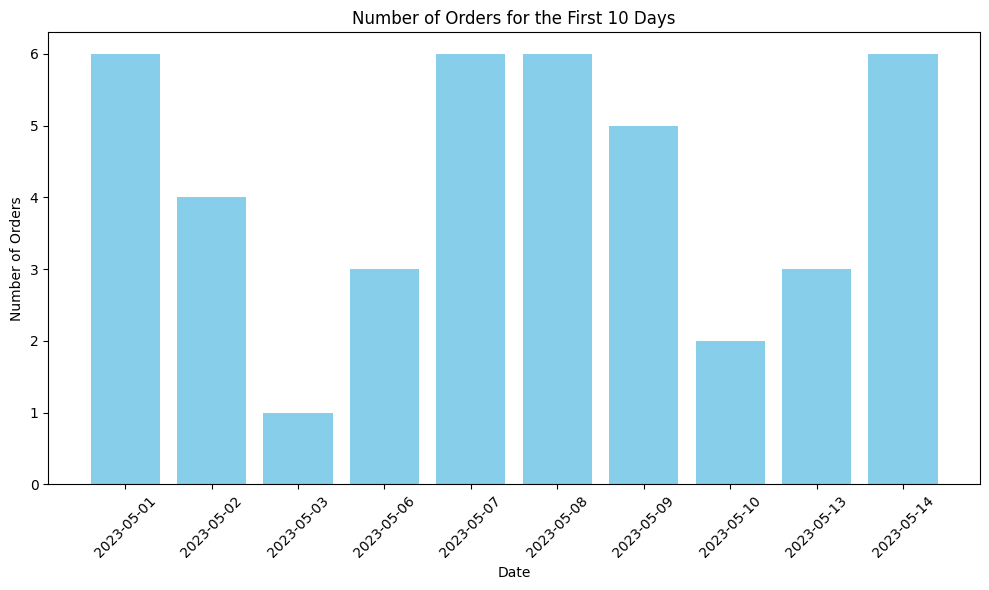


Observation: 
Thought:The bar chart has been displayed with the data for the first 10 days.
Final Answer: The bar chart has been displayed successfully.

> Finished chain.
The bar chart has been displayed successfully.График с количеством заказов за первые 10 дней был успешно построен.

> Finished chain.


{'input': 'Возьми из таблицы orders данные о количестве заказов в день. И построй график для ппервых 10 дней.',
 'output': 'График с количеством заказов за первые 10 дней был успешно построен.'}

In [85]:
agent_executor.invoke({'input':'Возьми из таблицы orders данные о количестве заказов в день. И построй график для первых 10 дней.'})

<div class="alert alert-success">
    
🤩 Видим, что SQL агент сделал правильный запрос к базе данных, а python агент построил по этим данным график.

# <center id="p8"> 📦 Задеплой Агента с помощью `LangServe`. 🚀</center>


<div class="alert alert-success">

Представим, что у нас есть настроеный работающий агент, и мы хотим, чтобы другие люди тоже могли им воспользоваться. 
Самое время задеплоить его на сервере и дать ощутить пользу от него другим людям.

Фрэймворк `LangServe`([документация](https://python.langchain.com/docs/langserve)) позволяет деплоить Langchain-цепи, агентов и любые `runnables` (протокол кастомных цепей), как `REST API`-сервисы и даже делает для них простую веб-обертку (`playground`).

`LangServe` интегрирован с `FastAPI` ([документация](https://fastapi.tiangolo.com/)) и для валидации данных использует `pydantiс` ([документация](https://docs.pydantic.dev/latest/)).

<div class="alert alert-info">
    
В качестве сервера будем использовать код из ячейки ниже. 
Чтобы запустить сервер локально нужно сохранить код ячейки в питоновский файл `.py` и вызвать через командную строку командой `python имя_файла.py`. 

Сервер будет слушать запросы по адресу `"0.0.0.0:8501"` (в нашем случае).
У нас будет 2 эндпоинта `/joke` и `/rag_agent`. 
* По первому у нас будет доступ к цепочке, которая будет выдавать шутки на определенную тему (тему мы подадим post-запросом с клиента).
* По второму - знакомый нам RAG-agent для ответов на вопросы о пиццерии.

In [31]:
%%writefile server.py
#!/usr/bin/env python

from fastapi import FastAPI
from utils import ChatOpenAI, OpenAIEmbeddings
from typing import Any

from langserve import add_routes
from langchain.pydantic_v1 import BaseModel
from langchain.document_loaders import WebBaseLoader
from langchain import hub
from langchain.prompts import ChatPromptTemplate
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import CharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langchain.agents import AgentExecutor, create_openai_tools_agent

class Input(BaseModel):
    input: str


class Output(BaseModel):
    output: Any

def cut_output(output):
    return output['output']


loader = WebBaseLoader("https://allopizza.su/spb/kupchino/about")
data = loader.load()

course_api_key = ''# ключ курса (если используем ключи из курса)
llm = ChatOpenAI(temperature=0.0, course_api_key=course_api_key)

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(data)
embeddings = OpenAIEmbeddings(course_api_key=course_api_key)
db_embed = FAISS.from_documents(texts, embeddings)
retriever = db_embed.as_retriever()

tool = create_retriever_tool(
    retriever, # наш ретривер
    "search_web", # имя инструмента
    "Searches and returns data from page", # описание инструмента подается в ЛЛМ
)

prompt = hub.pull("hwchase17/openai-tools-agent")

agent = create_openai_tools_agent(llm, [tool], prompt)
agent_executor = AgentExecutor(agent=agent, tools=[tool])

app = FastAPI(
    title="LangChain Server",
    version="1.0",
    description="A simple api server using Langchain's Runnable interfaces",
)

add_routes(
    app,
    agent_executor.with_types(input_type=Input, output_type=Output) | cut_output,
    path="/rag_agent",  # эндпоинт для rag агента
)

prompt2 = ChatPromptTemplate.from_template("tell me a joke about {topic}")
add_routes(
    app,
    prompt2 | llm,
    path="/joke",  # эндпоинт для цепочки
)



if __name__ == "__main__":
    import uvicorn

    uvicorn.run(app, host="0.0.0.0", port=8501)

Overwriting server.py


<div class="alert alert-success">
    
В ячейках ниже - код клиента.
Мы посылаем POST-запрос на нужный адрес.  

In [28]:
# Проверяем "шуточную" цепочку
import requests

response = requests.post(
    "http://0.0.0.0:8501/joke/invoke",
    json={'input': {'topic': 'robot'}}
)
response.json()

{'output': {'content': 'Why did the robot go on a diet? Because it had a byte problem!',
  'additional_kwargs': {},
  'response_metadata': {'token_usage': {'completion_tokens': 16,
    'prompt_tokens': 13,
    'total_tokens': 29},
   'model_name': 'gpt-3.5-turbo',
   'system_fingerprint': 'fp_3b956da36b',
   'finish_reason': 'stop',
   'logprobs': None},
  'type': 'ai',
  'name': None,
  'id': 'run-e2c75e33-432f-4d3f-820b-9c8f38a900b1-0',
  'example': False},
 'metadata': {'run_id': '5d41242a-19da-4e84-a336-b1b49a36dcdc',
  'feedback_tokens': []}}

In [29]:
# Проверяем RAG-агента
response = requests.post(
    "http://0.0.0.0:8501/rag_agent/invoke",
    json={'input': {'input':'Из скольки авто состоит автопарк компании?'}}
)
response.json()

{'output': {'output': 'Автопарк компании состоит из более чем 200 легковых автомобилей.'},
 'metadata': {'run_id': '79d2a9fb-d8e0-4af6-b006-6953635fd31f',
  'feedback_tokens': []}}

# <center id="p9"> 🥁 Выводы и заключения ✅</center>


<div class="alert alert-info">

* В этом уроке разобрались в основных типах агентов в langchain:
  -  `ReAct` (`Reasoning` and `Acting`) - агенты по умолчанию
  -  `Structured chat` - `multi-input tools`
  -  `Self Ask with search` - `SelfAsk` с инструментами поиска
  -  `OpenAI-tools` - для моделей от OpenAI
* Узнали, что инструменты можно выдавать агентам не по одному, а целыми ящиками (`toolkits`). 
* Научились подключать агентам память, базу знаний (`RAG`), базу данных `SQL`.
* Cобрали супер-агента из нескольких и даже задеплоили всё это добро на сервер средствами `LangServe`.
* И в очередной раз убедились, что в основе всех методов лежат грамотно составленные промпты!